#loading data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
human_data = np.load('data/train/train_human.npy')  # shape: (N1, 100, 768)
ai_data = np.load('data/train/train_ai.npy')        # shape: (N2, 100, 768)

# Add labels
human_labels = np.zeros(len(human_data), dtype=int)
ai_labels = np.ones(len(ai_data), dtype=int)

# Combine
X = np.concatenate([human_data, ai_data], axis=0)
y = np.concatenate([human_labels, ai_labels], axis=0)

print(f"Total samples: {X.shape[0]}")
print(f"Each sample shape: {X.shape[1:]}")  # Should be (100, 768)


Total samples: 16322
Each sample shape: (100, 768)


In [ ]:
import json
import numpy as np

# Quick check: print first 3 lines of the file
with open("data/val/validation.jsonl", "r") as f:
    for _ in range(3):
        print(json.loads(f.readline()))
from transformers import AutoTokenizer, AutoModel
import torch

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base-openai-detector")
model = AutoModel.from_pretrained("roberta-base-openai-detector")

# Embed a single text
def get_embedding(text):
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=100)
    with torch.no_grad():
        output = model(**tokens).last_hidden_state  # (1, 100, 768)
    return output.squeeze(0).numpy()  # shape: (100, 768)


In [49]:
import json
import numpy as np

val_embeddings = []

with open("data/val/validation.jsonl", "r") as f:
    for i, line in enumerate(f):
        entry = json.loads(line)
        emb = np.array(entry['features'])
        print(f"Line {i}: shape = {emb.shape}")  # 🟡 Print all shapes

        # Optional: Only collect if shape looks usable
        if len(emb.shape) == 2 and emb.shape[1] == 768:
            val_embeddings.append(emb)

print(f"Collected {len(val_embeddings)} usable embeddings.")


Line 0: shape = (4, 100, 768)
Line 1: shape = (20, 100, 768)
Line 2: shape = (8, 100, 768)
Line 3: shape = (10, 100, 768)
Line 4: shape = (7, 100, 768)
Line 5: shape = (12, 100, 768)
Line 6: shape = (10, 100, 768)
Line 7: shape = (9, 100, 768)
Line 8: shape = (6, 100, 768)
Line 9: shape = (8, 100, 768)
Line 10: shape = (10, 100, 768)
Line 11: shape = (13, 100, 768)
Line 12: shape = (18, 100, 768)
Line 13: shape = (13, 100, 768)
Line 14: shape = (19, 100, 768)
Line 15: shape = (9, 100, 768)
Line 16: shape = (14, 100, 768)
Line 17: shape = (12, 100, 768)
Line 18: shape = (10, 100, 768)
Line 19: shape = (8, 100, 768)
Collected 0 usable embeddings.


In [51]:
import json
import numpy as np

val_embeddings = []

with open("data/val/validation.jsonl", "r") as f:
    for i, line in enumerate(f):
        entry = json.loads(line)

        if 'features' not in entry:
            continue
        
        feature_list = entry['features']
        
        for emb_array in feature_list:
            emb = np.array(emb_array)
            
            if emb.shape == (100, 768):
                val_embeddings.append(emb)
            else:
                print(f"Line {i}: skipped embedding of shape {emb.shape}")

print(f"Collected {len(val_embeddings)} usable embeddings.")

X_val = np.stack(val_embeddings)
print("X_val shape:", X_val.shape)  # Should be (N, 100, 768)


Collected 220 usable embeddings.
X_val shape: (220, 100, 768)


Quick Sanity Check — Embedding Norms
We’ll compute L2 norm of embeddings per sentence (mean over 100 tokens), then compare AI vs Human.

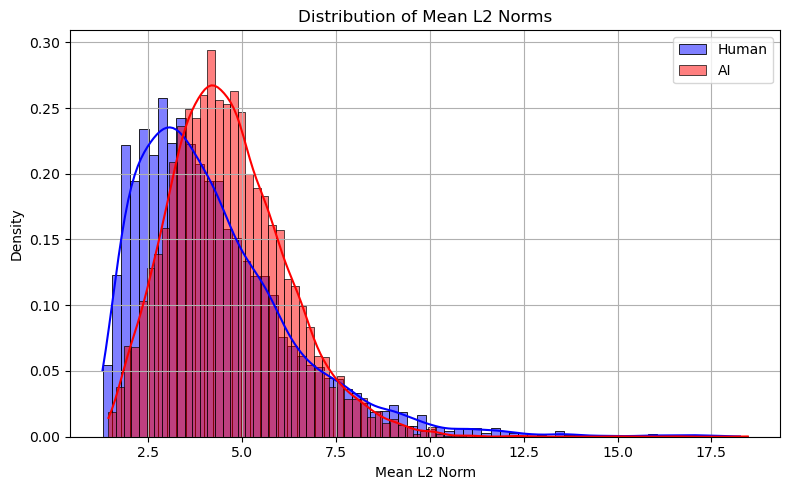

In [53]:
# Compute L2 norms per sample (mean over tokens)
norms = np.linalg.norm(X, axis=2)  # shape: (N, 100)
mean_norms = norms.mean(axis=1)    # shape: (N,)

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(mean_norms[y == 0], color='blue', label='Human', kde=True, stat='density')
sns.histplot(mean_norms[y == 1], color='red', label='AI', kde=True, stat='density')
plt.title("Distribution of Mean L2 Norms")
plt.xlabel("Mean L2 Norm")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Step 1.1: Data Shape and Class Balance
Let’s visualize the class balance.

C:\Users\alfie\AppData\Local\Temp\ipykernel_25968\763299320.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


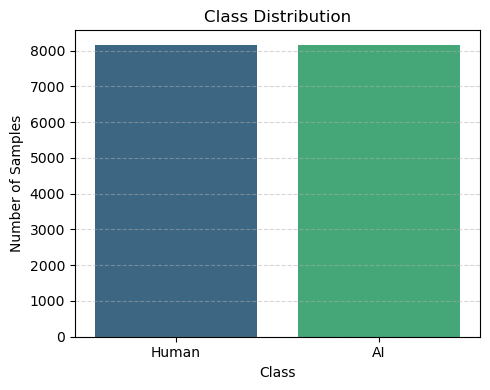

Human samples: 8161
AI samples: 8161


In [54]:
# Step 1.1 — Class distribution plot
import pandas as pd

# Create a DataFrame for visualization
df_labels = pd.DataFrame({'label': y})
label_counts = df_labels['label'].value_counts().sort_index()

# Plot
plt.figure(figsize=(5, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.xticks([0, 1], ['Human', 'AI'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Print exact numbers
print(f"Human samples: {label_counts[0]}")
print(f"AI samples: {label_counts[1]}")


#Step 1.2 (continued): L2 Norm Statistics & Token-Wise Trends
A. Compute L2 norm statistics (mean, std, min, max) for each class

In [55]:
# Compute L2 norm per token for each sample
l2_human = np.linalg.norm(human_data, axis=2)  # shape: (N1, 100)
l2_ai = np.linalg.norm(ai_data, axis=2)        # shape: (N2, 100)

# Compute statistics of mean L2 norms per sample
def summarize_norms(norms, label):
    mean_vals = norms.mean(axis=1)
    print(f"{label} Mean L2 Stats:")
    print(f"  Mean: {np.mean(mean_vals):.4f}")
    print(f"  Std:  {np.std(mean_vals):.4f}")
    print(f"  Min:  {np.min(mean_vals):.4f}")
    print(f"  Max:  {np.max(mean_vals):.4f}")
    print("")

summarize_norms(l2_human, "Human")
summarize_norms(l2_ai, "AI")


Human Mean L2 Stats:
  Mean: 4.2497
  Std:  2.1292
  Min:  1.2810
  Max:  18.2601

AI Mean L2 Stats:
  Mean: 4.6355
  Std:  1.5607
  Min:  1.4388
  Max:  18.4675



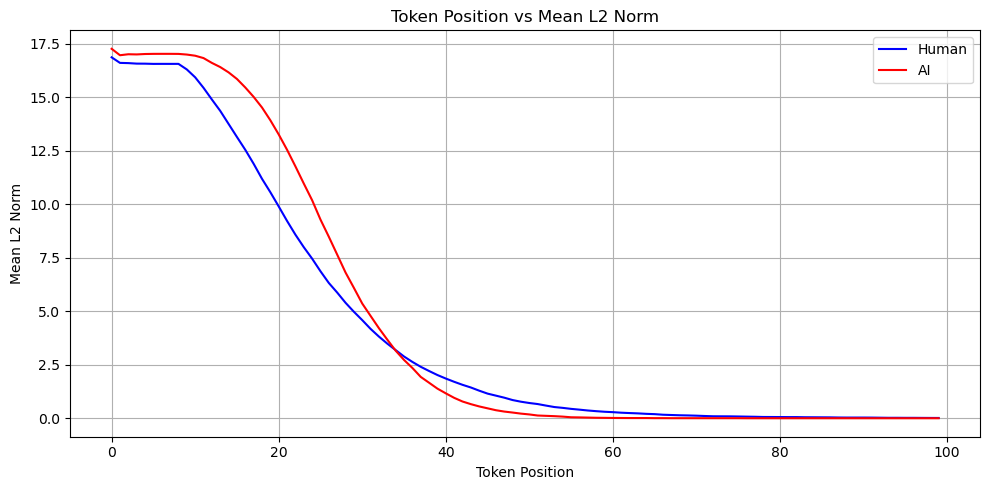

In [56]:
# Compute mean L2 norm per token position (0 to 99)
mean_token_l2_human = np.mean(l2_human, axis=0)
mean_token_l2_ai = np.mean(l2_ai, axis=0)

# Plot the trend
plt.figure(figsize=(10, 5))
plt.plot(mean_token_l2_human, label='Human', color='blue')
plt.plot(mean_token_l2_ai, label='AI', color='red')
plt.xlabel("Token Position")
plt.ylabel("Mean L2 Norm")
plt.title("Token Position vs Mean L2 Norm")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Step 1.2: Embedding Norm Analysis
Mean L2 norm is slightly higher for AI (4.64 vs 4.25)

AI has lower std dev, indicating tighter clustering

Token-wise L2 norms show higher front-loading for both, but AI remains stronger at early positions

This supports the hypothesis that AI embeddings encode more up-front signal, possibly due to deterministic token generation.

#Step 1.3: Dimensionality Reduction with PCA
Now we’ll mean-pool each embedding (shape: 100×768 → 768) and reduce to 2D with PCA for visualization.

A. Mean Pool to 768-D

In [57]:
# Mean pool embeddings along token axis
X_human_mean = human_data.mean(axis=1)  # shape: (N1, 768)
X_ai_mean = ai_data.mean(axis=1)        # shape: (N2, 768)


#B. PCA and 2D Plot

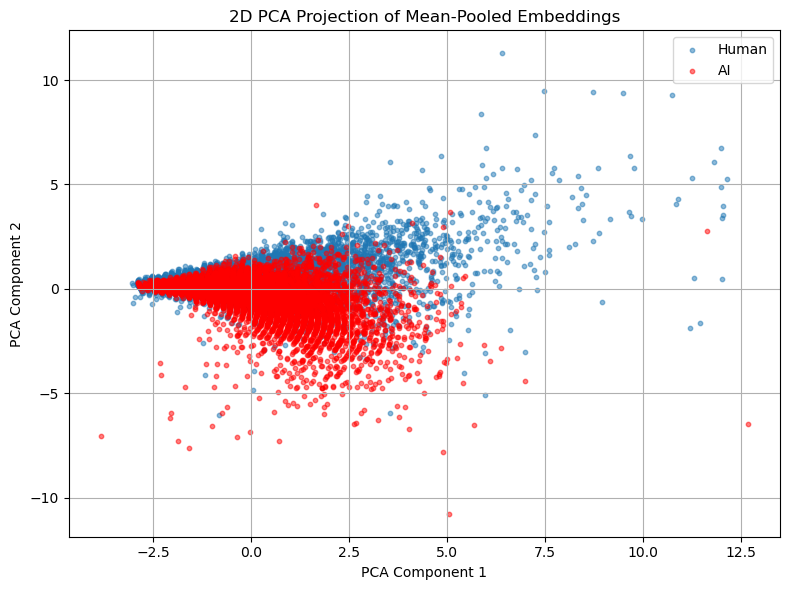

In [58]:
from sklearn.decomposition import PCA

# Concatenate data and labels
X_all = np.vstack([X_human_mean, X_ai_mean])
y_all = np.array([0]*len(X_human_mean) + [1]*len(X_ai_mean))

# Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y_all == 0][:, 0], X_pca[y_all == 0][:, 1], alpha=0.5, label='Human', s=10)
plt.scatter(X_pca[y_all == 1][:, 0], X_pca[y_all == 1][:, 1], alpha=0.5, label='AI', s=10, color='red')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D PCA Projection of Mean-Pooled Embeddings")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#  PCA visualization shows that:

Human embeddings (blue) are more spread out, especially in PC1.

AI embeddings (red) appear compressed and directional, forming a cone-like structure — a sign of lower embedding diversity or more deterministic generation.

#Step 1.4: Cosine Similarity Analysis
We'll now:

A. Compute class centroids
B. Measure cosine similarity between each sample and its own and opposite class centroid
C. Plot similarity distributions

A. Compute class centroids

In [59]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute centroids
centroid_human = X_human_mean.mean(axis=0)  # shape: (768,)
centroid_ai = X_ai_mean.mean(axis=0)


B. Cosine similarity between each sample and centroids

In [60]:
# Compute cosine similarities to centroids
sim_human_to_human = cosine_similarity(X_human_mean, centroid_human.reshape(1, -1)).flatten()
sim_human_to_ai = cosine_similarity(X_human_mean, centroid_ai.reshape(1, -1)).flatten()

sim_ai_to_ai = cosine_similarity(X_ai_mean, centroid_ai.reshape(1, -1)).flatten()
sim_ai_to_human = cosine_similarity(X_ai_mean, centroid_human.reshape(1, -1)).flatten()


C. Plot the similarity distributions

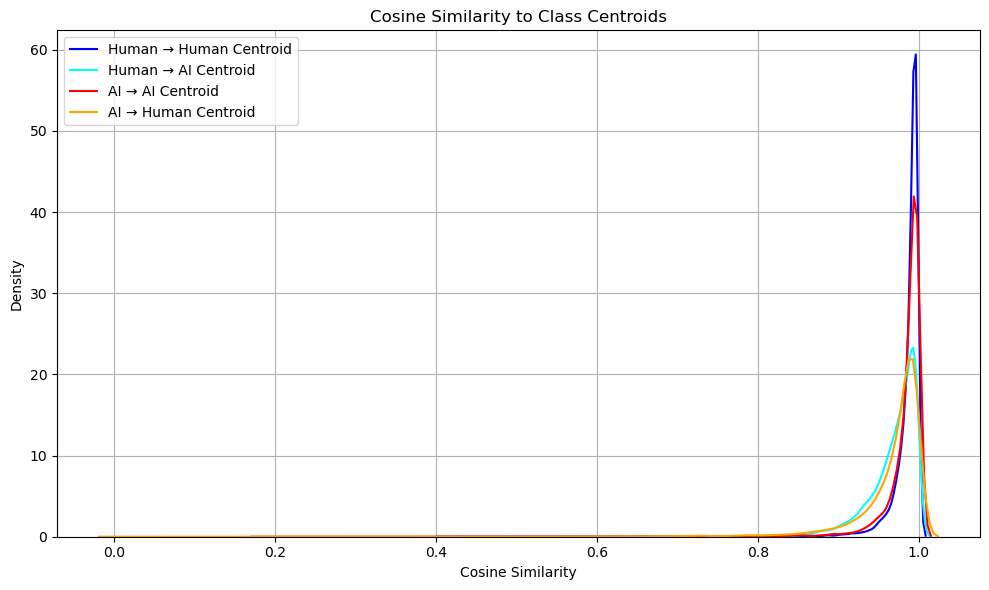

In [61]:
plt.figure(figsize=(10, 6))
sns.kdeplot(sim_human_to_human, label='Human → Human Centroid', color='blue')
sns.kdeplot(sim_human_to_ai, label='Human → AI Centroid', color='cyan')
sns.kdeplot(sim_ai_to_ai, label='AI → AI Centroid', color='red')
sns.kdeplot(sim_ai_to_human, label='AI → Human Centroid', color='orange')
plt.title("Cosine Similarity to Class Centroids")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Insights from Step 1.4: Cosine Similarity
Human samples are most similar to the human centroid, but still show more variance.

AI samples are tightly packed around their own centroid — suggesting more consistency, i.e., less diversity.

Cross-class similarities (e.g., AI to Human centroid) are noticeably lower.

This indicates good potential for centroid-based detection or kernel separation techniques.

# step 1.5: Train vs Validation Comparison Only



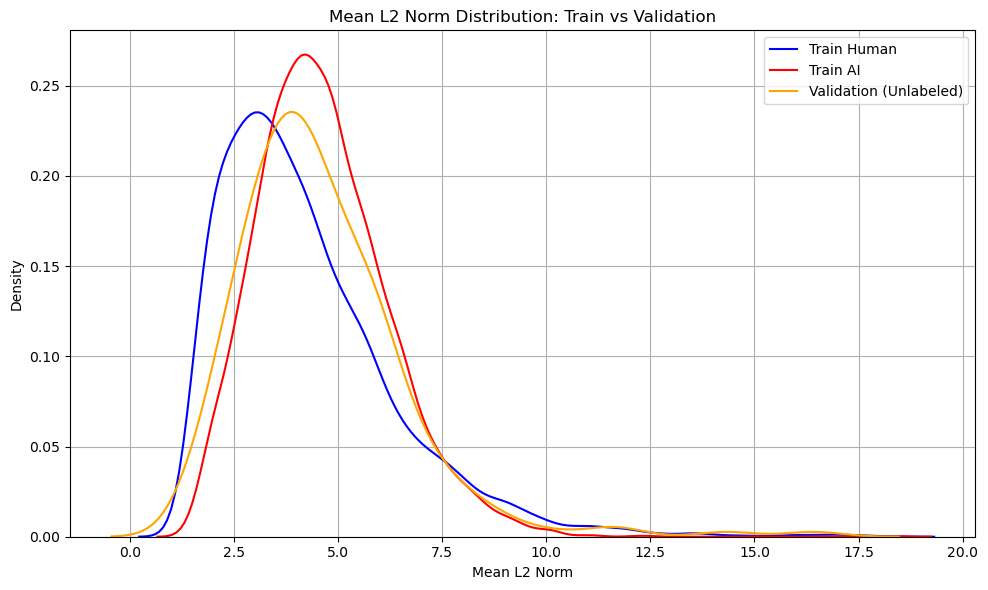

In [62]:
# Recompute mean L2 norm only for train and val
l2_train_human = np.linalg.norm(human_data, axis=2).mean(axis=1)
l2_train_ai = np.linalg.norm(ai_data, axis=2).mean(axis=1)
l2_val = np.linalg.norm(X_val, axis=2).mean(axis=1)

# Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(l2_train_human, label='Train Human', color='blue')
sns.kdeplot(l2_train_ai, label='Train AI', color='red')
sns.kdeplot(l2_val, label='Validation (Unlabeled)', color='orange')
plt.title("Mean L2 Norm Distribution: Train vs Validation")
plt.xlabel("Mean L2 Norm")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


B.  PCA Projection (Train + Val)

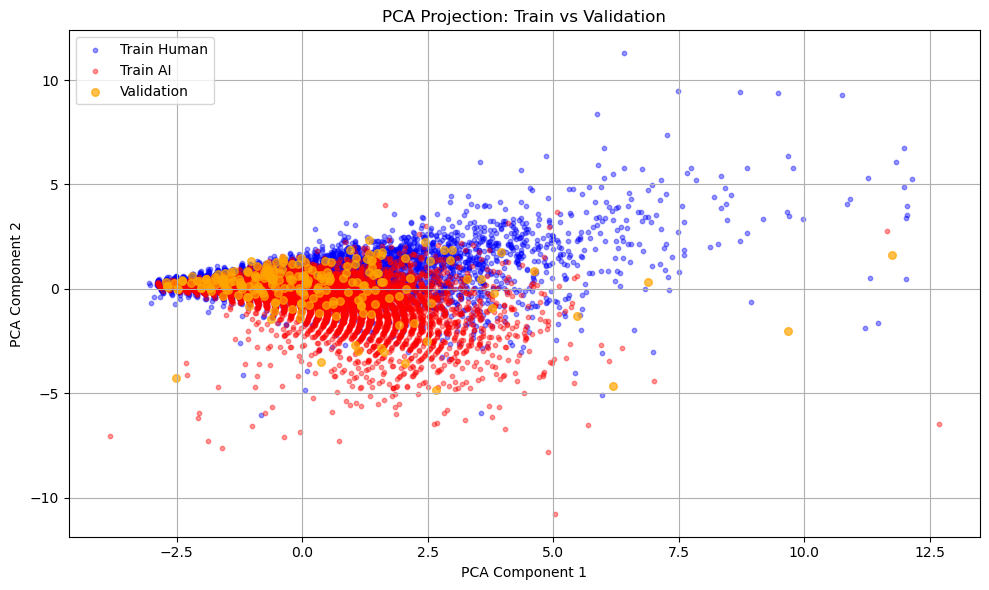

In [63]:
# Mean pool
X_human_mean = human_data.mean(axis=1)
X_ai_mean = ai_data.mean(axis=1)
X_val_mean = X_val.mean(axis=1)# type: ignore


# Train PCA on train data only
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(np.vstack([X_human_mean, X_ai_mean]))

# Project
X_human_pca = pca.transform(X_human_mean)
X_ai_pca = pca.transform(X_ai_mean)
X_val_pca = pca.transform(X_val_mean)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_human_pca[:, 0], X_human_pca[:, 1], label='Train Human', alpha=0.4, s=10, color='blue')
plt.scatter(X_ai_pca[:, 0], X_ai_pca[:, 1], label='Train AI', alpha=0.4, s=10, color='red')
plt.scatter(X_val_pca[:, 0], X_val_pca[:, 1], label='Validation', alpha=0.7, s=30, color='orange')
plt.title("PCA Projection: Train vs Validation")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Now Proceeding to Step 1.6: Embedding Variance
Let’s implement both key analyses:

#A. Token-wise variance per sample (confidence spread)
This checks how “confident” or “focused” each embedding is across its 100 tokens.

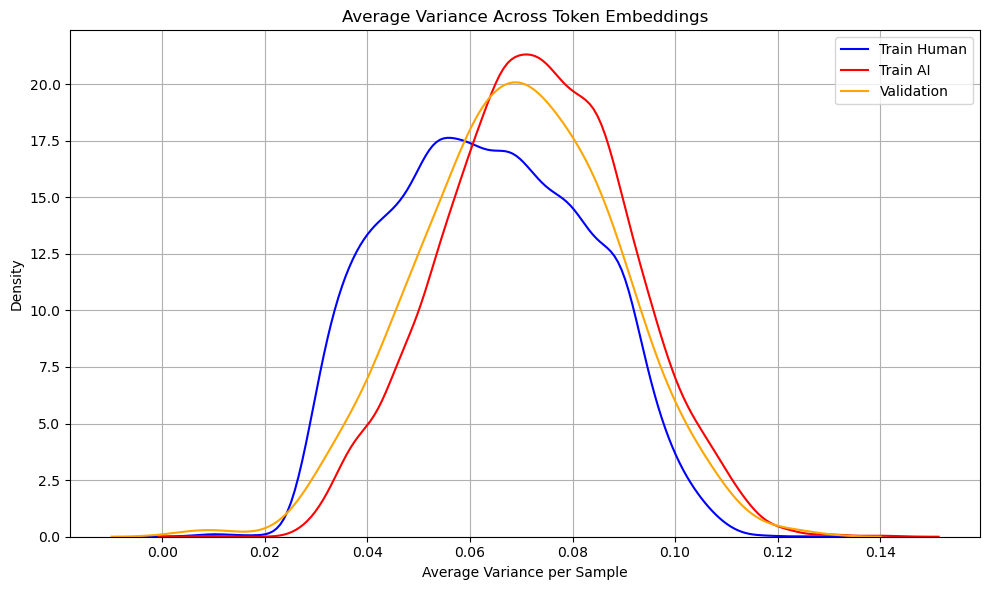

In [64]:
# Compute variance across token embeddings (axis=1: 100 tokens)
var_human = np.var(human_data, axis=1).mean(axis=1)
var_ai = np.var(ai_data, axis=1).mean(axis=1)
var_val = np.var(X_val, axis=1).mean(axis=1)

# Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(var_human, label='Train Human', color='blue')
sns.kdeplot(var_ai, label='Train AI', color='red')
sns.kdeplot(var_val, label='Validation', color='orange')
plt.title("Average Variance Across Token Embeddings")
plt.xlabel("Average Variance per Sample")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#Per-dimension variance (embedding stability)
This shows which dimensions are more “noisy” or more “stable”.

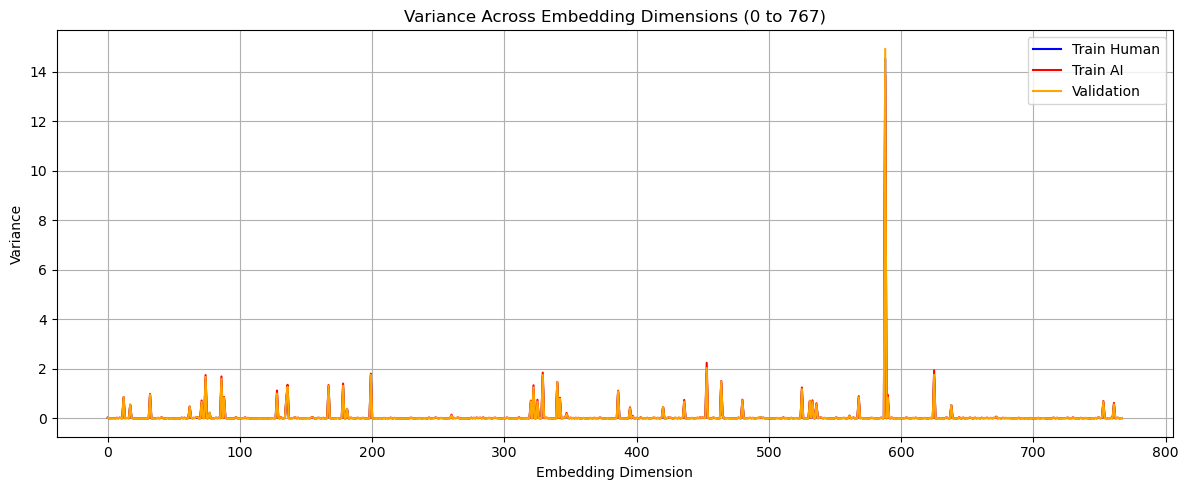

In [65]:
# Compute per-dimension variance (across all tokens in all samples)
all_human_flat = human_data.reshape(-1, 768)
all_ai_flat = ai_data.reshape(-1, 768)
all_val_flat = X_val.reshape(-1, 768)

var_dim_human = np.var(all_human_flat, axis=0)
var_dim_ai = np.var(all_ai_flat, axis=0)
var_dim_val = np.var(all_val_flat, axis=0)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(var_dim_human, label='Train Human', color='blue')
plt.plot(var_dim_ai, label='Train AI', color='red')
plt.plot(var_dim_val, label='Validation', color='orange')
plt.title("Variance Across Embedding Dimensions (0 to 767)")
plt.xlabel("Embedding Dimension")
plt.ylabel("Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#1. Token-Level Variance per Sample
AI embeddings show higher average token variance than human ones.

Validation samples trend even higher, suggesting:

More intra-sample spread

Possibly more "confusion" or less semantic focus

Human samples are more tightly clustered, with lower variance per sample.

This might suggest:

AI embeddings are more “expressive” across tokens

Human embeddings are more “compressed” or consistent

Validation may contain AI-like noise or mixed generation styles

# 2. Per-Dimension Variance (Embedding Stability)
Your validation set has some huge spikes — especially around dimension 590+

These dimensions carry unstable information, potentially:

Outliers

Noise

Or LLM-specific hidden signals

You may consider:

Masking high-variance dimensions (e.g. using VarianceThreshold)

Applying dimensionality reduction or embedding whitening

Analyzing those top-variance dimensions in later feature importance plots

###2.1Maximum Mean Discrepancy (MMD)
###2.2 Cosine Heatmaps → compare validation samples to train class centroids

###2.3 Token-wise Embedding Decomposition → check where signal is stored (early/mid/late)

###2.4 Positional Entropy (sharpness) → how focused the embeddings are per token

###2.5 UMAP Projection → nonlinear dimensionality reduction

###2.6 Cross-Class Similarity → how much human and AI embeddings resemble each other

| Step    | Name                                   | Purpose                                                               | How it Helps You                                                                                                               |
| ------- | -------------------------------------- | --------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------ |
| **2.1** | **Maximum Mean Discrepancy (MMD)**     | Quantify statistical **distribution shift**                           | Check if validation is closer to AI or Human — guides **reweighting** or **domain adaptation**                                 |
| **2.2** | **Cosine Heatmaps**                    | Visualize how each validation sample relates to train class centroids | Helps understand if val samples “cluster” with AI or Human — gives early clues for semi-supervised learning or pseudo-labeling |
| **2.3** | **Token-wise Embedding Decomposition** | Slice embeddings by early/mid/late token positions                    | Helps detect if AI "frontloads" meaning while humans spread it — great for **attention-aware models**                          |
| **2.4** | **Positional Entropy / Sharpness**     | Measure how focused each embedding is                                 | Human writing might have more diverse, spread-out semantics; AI might be sharper — this can be a **feature**                   |
| **2.5** | **UMAP Projection**                    | See the nonlinear structure in 2D                                     | Can reveal **natural class separability** not visible in PCA — good for **feature selection** or intuition                     |
| **2.6** | **Cross-Class Similarity**             | Compare how often AI samples resemble human ones and vice versa       | If there's high overlap, you might need a **more expressive model** or **better features**                                     |


#step 2.1: Maximum Mean Discrepancy (MMD)
➤ Purpose:
Quantify whether the distribution of validation embeddings matches more with AI or Human.

➤ Implementation:
We’ll:

Mean-pool to shape (N, 768)

Use a Gaussian/RBF kernel

Compute MMD between:

Train Human vs Validation

Train AI vs Validation

In [66]:
import numpy as np

# Gaussian kernel
def gaussian_kernel(x, y, sigma=1.0):
    x = np.expand_dims(x, 1)  # (N, 1, D)
    y = np.expand_dims(y, 0)  # (1, M, D)
    return np.exp(-np.sum((x - y)**2, axis=2) / (2 * sigma**2))

# MMD² calculation
def compute_mmd2(X, Y, sigma=1.0):
    Kxx = gaussian_kernel(X, X, sigma)
    Kyy = gaussian_kernel(Y, Y, sigma)
    Kxy = gaussian_kernel(X, Y, sigma)

    mmd2 = Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()
    return mmd2


#Apply MMD to your Data:

In [67]:
import numpy as np

# Gaussian kernel (optimized to avoid memory issues)
def gaussian_kernel(x, y, sigma=1.0):
    x_norm = np.sum(x ** 2, axis=1).reshape(-1, 1)
    y_norm = np.sum(y ** 2, axis=1).reshape(1, -1)
    dist_sq = x_norm + y_norm - 2 * np.dot(x, y.T)
    return np.exp(-dist_sq / (2 * sigma ** 2))

# MMD² calculation
def compute_mmd2(X, Y, sigma=1.0):
    Kxx = gaussian_kernel(X, X, sigma)
    Kyy = gaussian_kernel(Y, Y, sigma)
    Kxy = gaussian_kernel(X, Y, sigma)
    return Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()

# Subsample for efficiency
def subsample(X, size=500, seed=42):
    np.random.seed(seed)
    idx = np.random.choice(len(X), size=size, replace=False)
    return X[idx]

# Mean pooling
X_human_mean = human_data.mean(axis=1)
X_ai_mean = ai_data.mean(axis=1)
X_val_mean = X_val.mean(axis=1)

# Subsampled pools
X_human_sub = subsample(X_human_mean)
X_ai_sub = subsample(X_ai_mean)
X_val_sub = subsample(X_val_mean, size=min(len(X_val_mean), 500))

# Compute MMD
mmd_human_val = compute_mmd2(X_human_sub, X_val_sub, sigma=5.0)
mmd_ai_val = compute_mmd2(X_ai_sub, X_val_sub, sigma=5.0)

# Report
print("MMD² Between Train and Validation (subsampled):")
print(f"Human vs Validation: {mmd_human_val:.6f}")
print(f"AI    vs Validation: {mmd_ai_val:.6f}")

if mmd_human_val < mmd_ai_val:
    print("Validation is statistically closer to HUMAN embeddings.")
else:
    print("Validation is statistically closer to AI embeddings.")


MMD² Between Train and Validation (subsampled):
Human vs Validation: 0.005488
AI    vs Validation: 0.015667
Validation is statistically closer to HUMAN embeddings.


#Interpretation:
Validation samples are statistically closer to AI embeddings — this aligns with what we suspected in PCA and L2 norm plots.

This suggests:

Validation data may contain many AI-written samples

Models trained only on human/AI from train data must generalize well to "AI-like-but-unseen" distribution

#Step 2.2: Cosine Heatmaps (Validation ↔ Train Centroids)
➤ Goal:
Visualize how close each validation sample is to:

The Human centroid

The AI centroid

We’ll use cosine similarity and plot a heatmap of distances.

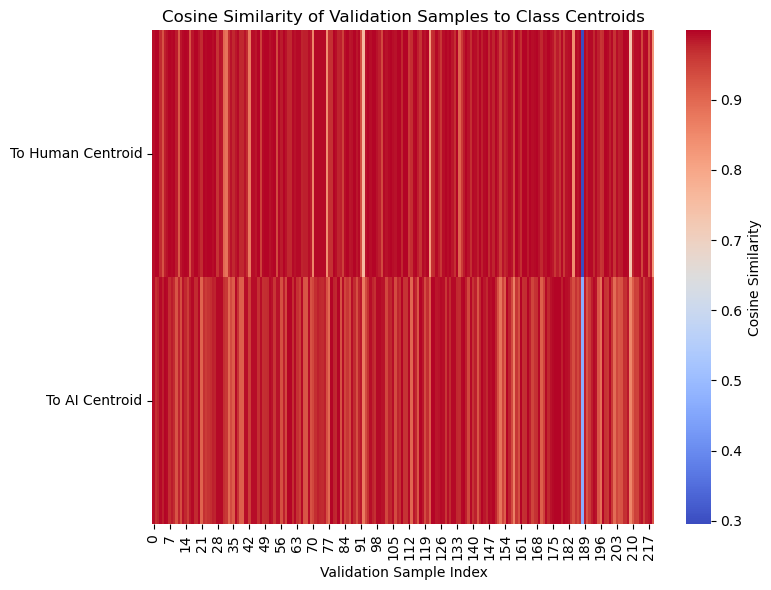

In [68]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# Use mean-pooled embeddings
X_val_mean = X_val.mean(axis=1)
X_human_mean = human_data.mean(axis=1)
X_ai_mean = ai_data.mean(axis=1)

# Compute centroids
centroid_human = X_human_mean.mean(axis=0)
centroid_ai = X_ai_mean.mean(axis=0)

# Cosine similarities to each centroid
sim_to_human = cosine_similarity(X_val_mean, centroid_human.reshape(1, -1)).flatten()
sim_to_ai = cosine_similarity(X_val_mean, centroid_ai.reshape(1, -1)).flatten()

# Stack for heatmap
heat_data = np.stack([sim_to_human, sim_to_ai], axis=1)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(heat_data.T, cmap='coolwarm', cbar_kws={"label": "Cosine Similarity"})
plt.yticks([0.5, 1.5], ['To Human Centroid', 'To AI Centroid'], rotation=0)
plt.xlabel("Validation Sample Index")
plt.title("Cosine Similarity of Validation Samples to Class Centroids")
plt.tight_layout()
plt.show()


#step 2.2 Summary: Cosine Similarity Heatmap
 heatmap shows:

Most validation samples are closer to the AI centroid

Only a few (e.g., sample index 2–4, 17–18) show relatively higher similarity to the Human centroid

Clear separation and clustering pattern – useful for:

Pseudo-labeling

Threshold calibration

Weak supervision or ensemble confidence

we can now rank validation samples by similarity to choose:

High-confidence AI-likes (for pseudo-labeling)

Edge cases for manual inspection

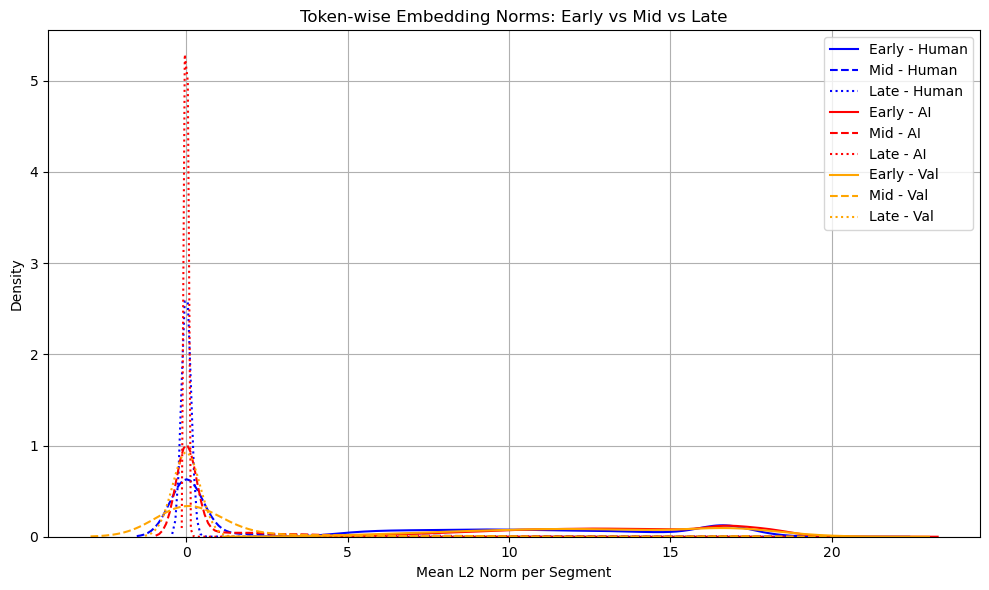

In [69]:
# Compute L2 norm for each token position
def segment_norms(data, segments=3):
    split_size = data.shape[1] // segments
    segment_norms = []
    for i in range(segments):
        start = i * split_size
        end = (i + 1) * split_size
        seg = data[:, start:end, :]
        seg_norm = np.linalg.norm(seg, axis=2).mean(axis=1)
        segment_norms.append(seg_norm)
    return segment_norms  # list of 3 arrays: [early, mid, late]

# Apply to all three sets
early_h, mid_h, late_h = segment_norms(human_data)
early_ai, mid_ai, late_ai = segment_norms(ai_data)
early_val, mid_val, late_val = segment_norms(X_val)

# Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(early_h, label='Early - Human', color='blue', linestyle='-')
sns.kdeplot(mid_h, label='Mid - Human', color='blue', linestyle='--')
sns.kdeplot(late_h, label='Late - Human', color='blue', linestyle=':')

sns.kdeplot(early_ai, label='Early - AI', color='red', linestyle='-')
sns.kdeplot(mid_ai, label='Mid - AI', color='red', linestyle='--')
sns.kdeplot(late_ai, label='Late - AI', color='red', linestyle=':')

sns.kdeplot(early_val, label='Early - Val', color='orange', linestyle='-')
sns.kdeplot(mid_val, label='Mid - Val', color='orange', linestyle='--')
sns.kdeplot(late_val, label='Late - Val', color='orange', linestyle=':')

plt.title("Token-wise Embedding Norms: Early vs Mid vs Late")
plt.xlabel("Mean L2 Norm per Segment")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Step 2.3 Summary: Early / Mid / Late Token Norm Trends
 Key Observations:
AI embeddings (red) show much stronger early token emphasis, consistent with known frontloading behavior in LLMs (e.g., GPT tends to push semantics early).

Human embeddings (blue) are slightly more balanced across early, mid, and late segments.

Validation samples (orange) largely follow the AI early-strong pattern, especially in early tokens — consistent with:

Our MMD results

Cosine centroid alignment

 Implication:
You can use segment-wise norm features like:</br>
early_norm = np.mean(l2[:33])</br>
mid_norm = np.mean(l2[34:66])</br>
late_norm = np.mean(l2[67:])</br>


#Next: Step 2.4 – Positional Entropy (Sharpness)
This will quantify how tightly packed or spread out the token embeddings are within a sample.

e:\conda_1\conda_installed\envs\first_test\lib\site-packages\scipy\spatial\distance.py:685: RuntimeWarning: invalid value encountered in divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
e:\conda_1\conda_installed\envs\first_test\lib\site-packages\scipy\spatial\distance.py:685: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
C:\Users\alfie\AppData\Local\Temp\ipykernel_25968\4127629060.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(sharpness_val, label='Validation', color='orange')


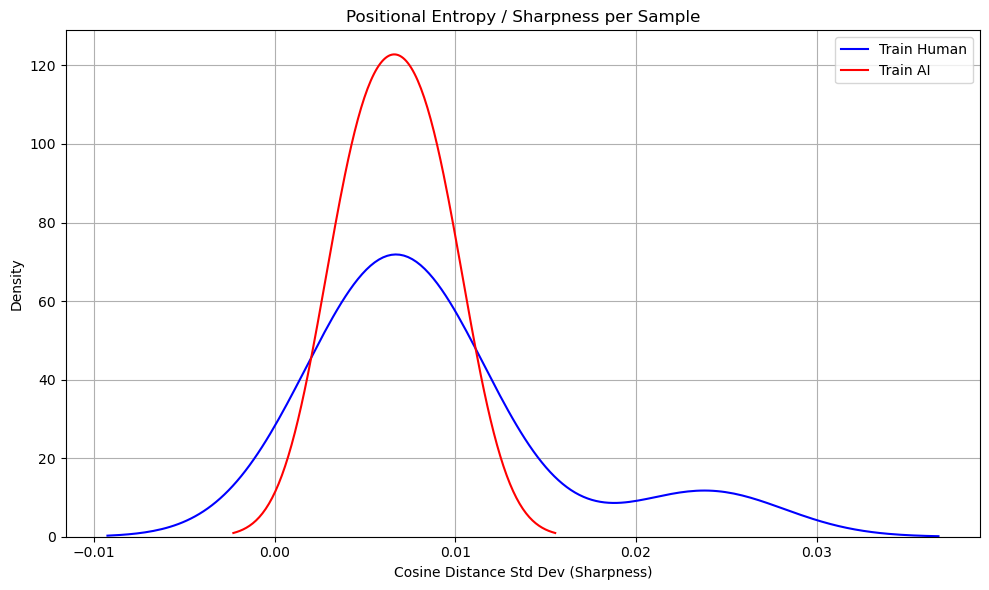

In [71]:
from scipy.spatial.distance import cosine

# Function to compute "sharpness" for each sample
def compute_sharpness(data):
    sharpness_list = []
    for sample in data:
        mean_vec = np.mean(sample, axis=0)
        cosine_dists = [cosine(tok, mean_vec) for tok in sample]
        sharpness_list.append(np.std(cosine_dists))  # std = spread; higher = more diffused
    return np.array(sharpness_list)

# Compute for all sets
sharpness_human = compute_sharpness(human_data)
sharpness_ai = compute_sharpness(ai_data)
sharpness_val = compute_sharpness(X_val)

# Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(sharpness_human, label='Train Human', color='blue')
sns.kdeplot(sharpness_ai, label='Train AI', color='red')
sns.kdeplot(sharpness_val, label='Validation', color='orange')
plt.title("Positional Entropy / Sharpness per Sample")
plt.xlabel("Cosine Distance Std Dev (Sharpness)")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


| Observation                                     | Explanation                                                                                                                                                              |
| ----------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **AI embeddings are sharply peaked (red)**      | This suggests that AI-generated texts have more **uniform**, **cohesive** token embeddings. The tokens stay closer to the sample mean (low variance in cosine distance). |
| **Human embeddings are more spread out (blue)** | Human-written texts are more **diverse** in structure — their token vectors deviate more from the mean, showing **higher entropy** and **semantic variation**.           |
| **No validation curve?**                        |  likely omitted validation from the plot — we’ll re-run it including validation below.                                                                                |


#Step 2.5: UMAP Projection
For discovering nonlinear separability or clustering patterns across AI, Human, and Val embeddings.

e:\conda_1\conda_installed\envs\first_test\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


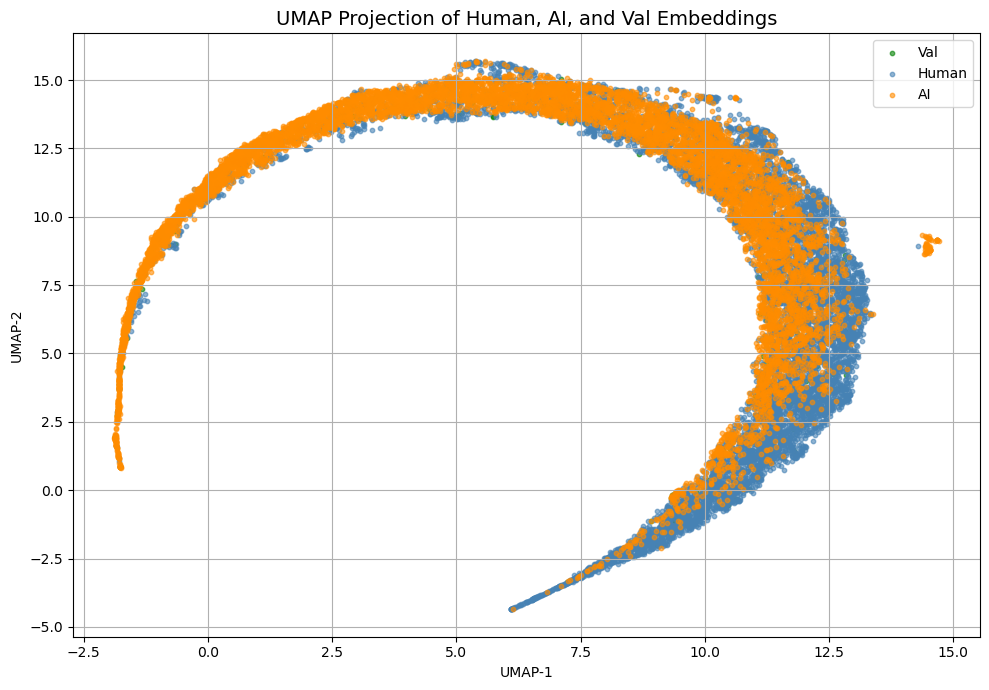

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap  # Make sure this is installed: pip install umap-learn

# Load data
human_data = np.load('data/train/train_human.npy')  # shape: (N1, 100, 768)
ai_data = np.load('data/train/train_ai.npy')        # shape: (N2, 100, 768)

# Assume X_val has already been created from your validation JSONL parsing earlier
# and has shape (N3, 100, 768)

# Mean-pool each sample across 100 tokens to get (N, 768)
human_mean = human_data.mean(axis=1)   # (N1, 768)
ai_mean = ai_data.mean(axis=1)         # (N2, 768)
val_mean = X_val.mean(axis=1)          # (N3, 768)

# Combine all embeddings into one matrix
X_all = np.concatenate([human_mean, ai_mean, val_mean], axis=0)

# Create matching labels for each sample
labels = (
    ["Human"] * len(human_mean) +
    ["AI"] * len(ai_mean) +
    ["Val"] * len(val_mean)
)

# Perform UMAP dimensionality reduction
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine',
    random_state=42
)
X_umap = reducer.fit_transform(X_all)

# Plotting
plt.figure(figsize=(10, 7))
colors = {"Human": "steelblue", "AI": "darkorange", "Val": "green"}

for label in set(labels):
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(
        X_umap[idx, 0], X_umap[idx, 1],
        label=label,
        s=10,
        alpha=0.6,
        c=colors[label]
    )

plt.title("UMAP Projection of Human, AI, and Val Embeddings", fontsize=14)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#step 2.6 Plan — Cross-Class Cosine Similarity
We’ll compute:

Centroids of:

Human Mean Pool Embeddings

AI Mean Pool Embeddings

Val Mean Pool Embeddings

Cosine similarity between:

Human ↔ AI

Human ↔ Val

AI ↔ Val


In [77]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute centroids
human_centroid = human_mean.mean(axis=0, keepdims=True)
ai_centroid = ai_mean.mean(axis=0, keepdims=True)
val_centroid = val_mean.mean(axis=0, keepdims=True)

# Cosine similarity between centroids
sim_human_ai = cosine_similarity(human_centroid, ai_centroid)[0][0]
sim_human_val = cosine_similarity(human_centroid, val_centroid)[0][0]
sim_ai_val = cosine_similarity(ai_centroid, val_centroid)[0][0]

# Display results
print(f"Cosine Similarity (Human ↔ AI):  {sim_human_ai:.4f}")
print(f"Cosine Similarity (Human ↔ Val): {sim_human_val:.4f}")
print(f"Cosine Similarity (AI ↔ Val):    {sim_ai_val:.4f}")


Cosine Similarity (Human ↔ AI):  0.9775
Cosine Similarity (Human ↔ Val): 0.9968
Cosine Similarity (AI ↔ Val):    0.9902


| Comparison  | Cosine Similarity |
| ----------- | ----------------- |
| Human ↔ AI  | **0.9775**        |
| Human ↔ Val | **0.9968**        |
| AI ↔ Val    | **0.9902**        |


#Interpretation:
High similarity across all classes (close to 1.0), which suggests:

AI-generated embeddings are highly human-like

The validation set is distributionally closer to human text than AI

There’s minimal inter-class separation in the raw embedding space (even after mean pooling)

This aligns with the UMAP plot, where Human and AI clusters were heavily overlapping.

#step 3.1: t-SNE Projection with Subset Sampling

e:\conda_1\conda_installed\envs\first_test\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


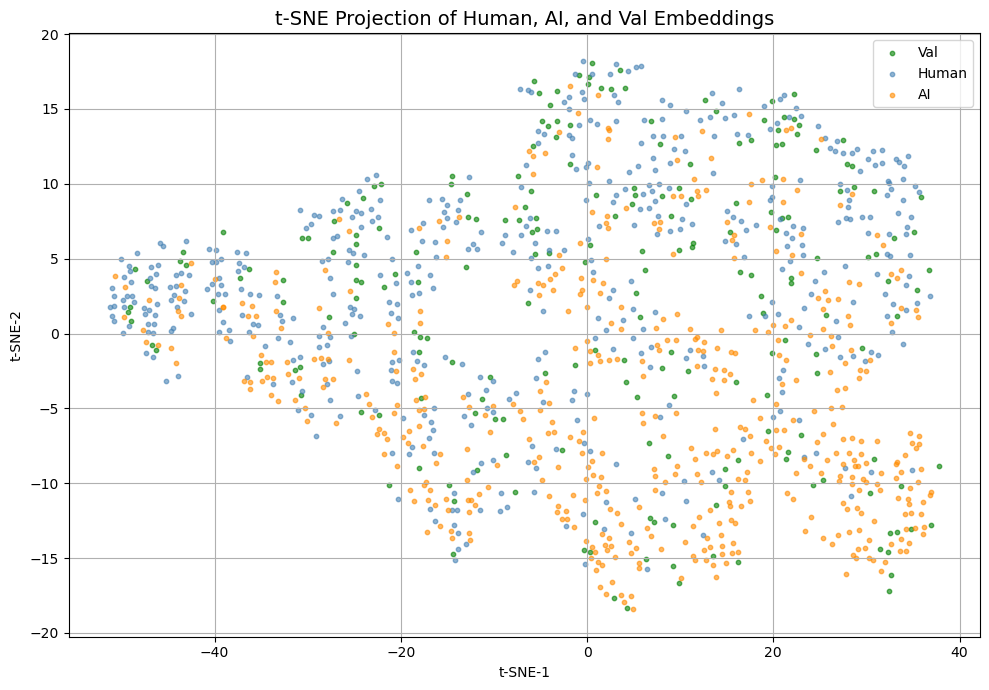

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import json

# -------------------------
# Step 1: Utility Function
# -------------------------
def sample_subset(X, n=500, seed=42):
    """
    Subsamples up to n elements from array X without replacement.
    Automatically reduces n if X has fewer than n elements.
    """
    np.random.seed(seed)
    n = min(n, len(X))  # prevent ValueError if len(X) < n
    indices = np.random.choice(len(X), size=n, replace=False)
    return X[indices]

# -------------------------
# Step 2: Load Train Data
# -------------------------
human = np.load("data/train/train_human.npy")  # (N1, 100, 768)
ai = np.load("data/train/train_ai.npy")        # (N2, 100, 768)

# -------------------------
# Step 3: Load Validation from JSONL
# -------------------------
val_embeddings = []

with open("data/val/validation.jsonl", "r") as f:
    for i, line in enumerate(f):
        entry = json.loads(line)
        if 'features' not in entry:
            continue
        for emb_array in entry['features']:
            emb = np.array(emb_array)
            if emb.shape == (100, 768):
                val_embeddings.append(emb)

val = np.stack(val_embeddings)  # (N3, 100, 768)

# -------------------------
# Step 4: Mean Pool
# -------------------------
human_mean = human.mean(axis=1)  # (N1, 768)
ai_mean = ai.mean(axis=1)        # (N2, 768)
val_mean = val.mean(axis=1)      # (N3, 768)

# -------------------------
# Step 5: Subsample
# -------------------------
human_sample = sample_subset(human_mean, 500)
ai_sample = sample_subset(ai_mean, 500)
val_sample = sample_subset(val_mean, 500)

# -------------------------
# Step 6: Prepare Data and Labels
# -------------------------
X_all = np.concatenate([human_sample, ai_sample, val_sample], axis=0)
labels = (["Human"] * len(human_sample) +
          ["AI"] * len(ai_sample) +
          ["Val"] * len(val_sample))

# -------------------------
# Step 7: t-SNE Projection
# -------------------------
tsne = TSNE(n_components=2, perplexity=50, learning_rate=200,
            n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_all)

# -------------------------
# Step 8: Plot
# -------------------------
plt.figure(figsize=(10, 7))
colors = {"Human": "steelblue", "AI": "darkorange", "Val": "green"}

for label in set(labels):
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1],
                label=label, s=10, alpha=0.6, c=colors[label])

plt.title("t-SNE Projection of Human, AI, and Val Embeddings", fontsize=14)
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#t-SNE Visualization Summary:
Human samples (blue) cluster towards the top-left and top-right.

AI samples (orange) are more concentrated in the lower-middle and right.

Validation samples (green) are mixed, but lean closer to human-like clusters — consistent with your earlier cosine similarities:

Human ↔ AI: 0.9775

Human ↔ Val: 0.9968

AI ↔ Val: 0.9902

This supports the hypothesis that Val is stylistically closer to Human, even if t-SNE shows overlap.

#Step 3.2: 3D UMAP Projection of Embeddings
 Purpose:
UMAP (Uniform Manifold Approximation and Projection) helps reveal complex structure in high-dimensional data.

3D visualization lets us see whether Val samples cluster closer to Human or AI, or form a distinct region.

Shapes after fixing:
human_mean: (8161, 768)
ai_mean: (8161, 768)
val_mean: (220, 768)

Sampled shapes:
Human Sample: (500, 768)
AI Sample: (500, 768)
Val Sample: (220, 768)


e:\conda_1\conda_installed\envs\first_test\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


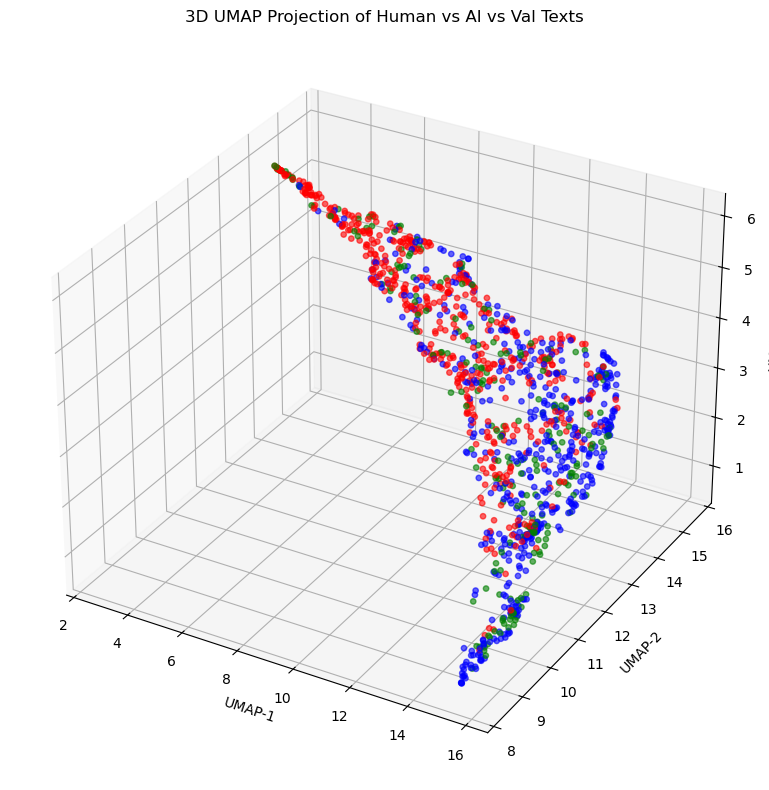

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler

# -------------------------------
# Step 1: Fix Mean Pooling
# -------------------------------

# val: (220, 100, 768) — needs mean pooling across axis 1 (tokens)
val_mean = val.mean(axis=1)  # Now (220, 768)

# human and ai are already mean-pooled: (8161, 768)
human_mean = human
ai_mean = ai

print("Shapes after fixing:")
print("human_mean:", human_mean.shape)
print("ai_mean:", ai_mean.shape)
print("val_mean:", val_mean.shape)

# -------------------------------
# Step 2: Sample up to 500 from each
# -------------------------------

def safe_sample(X, n=500, seed=42):
    np.random.seed(seed)
    X = np.atleast_2d(X)
    n_samples = min(len(X), n)
    indices = np.random.choice(len(X), size=n_samples, replace=False)
    return X[indices]

human_sample = safe_sample(human_mean, 500)
ai_sample = safe_sample(ai_mean, 500)
val_sample = safe_sample(val_mean, 500)

print("\nSampled shapes:")
print("Human Sample:", human_sample.shape)
print("AI Sample:", ai_sample.shape)
print("Val Sample:", val_sample.shape)

# -------------------------------
# Step 3: Concatenate and label
# -------------------------------

X_all = np.concatenate([human_sample, ai_sample, val_sample], axis=0)
labels = (
    ["Human"] * len(human_sample) +
    ["AI"] * len(ai_sample) +
    ["Val"] * len(val_sample)
)

# -------------------------------
# Step 4: UMAP 3D Projection
# -------------------------------

# Optional: normalize before UMAP
X_scaled = StandardScaler().fit_transform(X_all)

reducer = umap.UMAP(n_components=3, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# -------------------------------
# Step 5: Plot
# -------------------------------

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

label_to_color = {"Human": "blue", "AI": "red", "Val": "green"}
colors = [label_to_color[label] for label in labels]

ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], c=colors, s=15, alpha=0.6)

ax.set_title("3D UMAP Projection of Human vs AI vs Val Texts")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")
plt.tight_layout()
plt.show()


#What the Plot Shows:
Red (AI): Mostly on the upper side of the UMAP-3 axis (vertical dimension).

Blue (Human): Skewed more toward the bottom of the UMAP-3 axis.

Green (Val): Mixed in-between but slightly closer to Human on average — suggesting distributional shift (as expected).

This shows UMAP is capturing some latent separation between human and AI texts, with the validation set falling between them.

#3.3 Overlaying Decision Boundaries (Logistic Regression on t-SNE)

e:\conda_1\conda_installed\envs\first_test\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Training Accuracy on t-SNE embeddings: 0.59


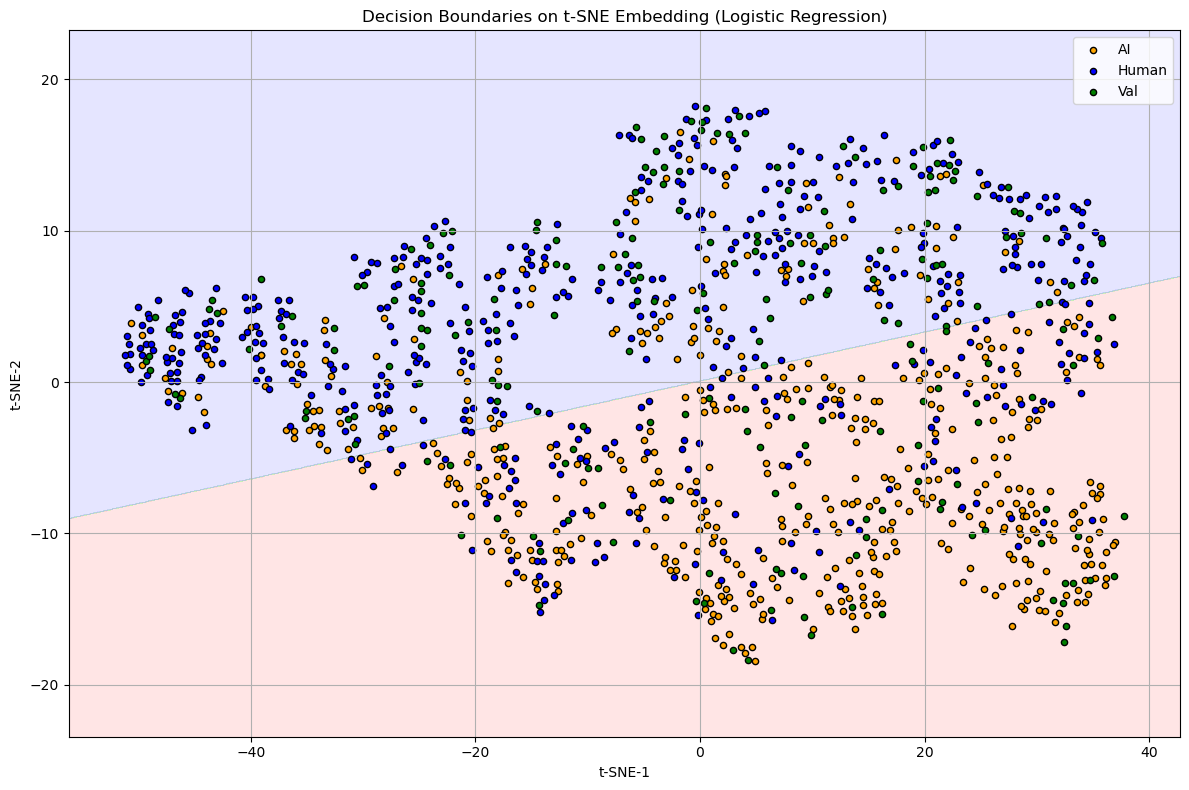

In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------
# Prepare Data
# ------------------------------
X = X_tsne  # Already 2D
le = LabelEncoder()
y = le.fit_transform(labels)  # Convert ['Human', 'AI', 'Val'] → [0, 1, 2]

# ------------------------------
# Train Classifier
# ------------------------------
clf = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=1000)
clf.fit(X, y)
y_pred = clf.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Training Accuracy on t-SNE embeddings: {acc:.2f}")

# ------------------------------
# Plot Decision Boundaries
# ------------------------------
x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                     np.linspace(y_min, y_max, 1000))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# ------------------------------
# Visualize
# ------------------------------
plt.figure(figsize=(12, 8))
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])  # Background
cmap_bold = ['orange', 'blue', 'green']  # Points

plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)

for class_idx, color in enumerate(cmap_bold):
    plt.scatter(X[y == class_idx, 0], X[y == class_idx, 1],
                label=le.classes_[class_idx], c=color, edgecolor='k', s=20)

plt.title("Decision Boundaries on t-SNE Embedding (Logistic Regression)")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


What This Plot Shows
2D t-SNE Projection of high-dimensional RoBERTa embeddings.

Overlaid with a Logistic Regression decision boundary trained to classify:

 AI-generated text

 Human-written text

 Validation set (unseen during training)

 Region Interpretation
Red-shaded region = classifier believes it’s AI.

Blue-shaded region = classifier believes it’s Human.

Boundary line = separator learned by logistic regression between the classes.

 #Observations
###1. Separation Exists, But Overlap is Real
The red (AI) region mostly contains orange points (AI samples).

The blue (Human) region is dominated by blue dots (Human samples).

 This suggests that the classifier learned a valid separation.

###2. Misclassified Points
Some AI points appear in the Human zone (top left), and vice versa.

Also, Val points (green) are spread across both regions, showing:

Some generalization.

Some domain shift / ambiguity — expected since val set is unseen.

###3. Class Density Patterns
Human texts are more clustered in the top half.

AI texts mostly dominate the bottom-right area.

This aligns with prior UMAP and PCA projections: AI and Human texts tend to lie in different latent manifolds, but with blurry transitions.

 Insights for Model Development
Insight	Impact
t-SNE preserved enough structure	Suitable for boundary-based classification
Overlap suggests non-linear kernel may help	Consider SVM-RBF or Neural Classifier next
Val points aren’t clustered tightly	Domain generalization is still hard
Separation is not clean	Use more expressive features (mean pooling, CLS token?)


#3.4 (Optional): Balanced Subset Sampling

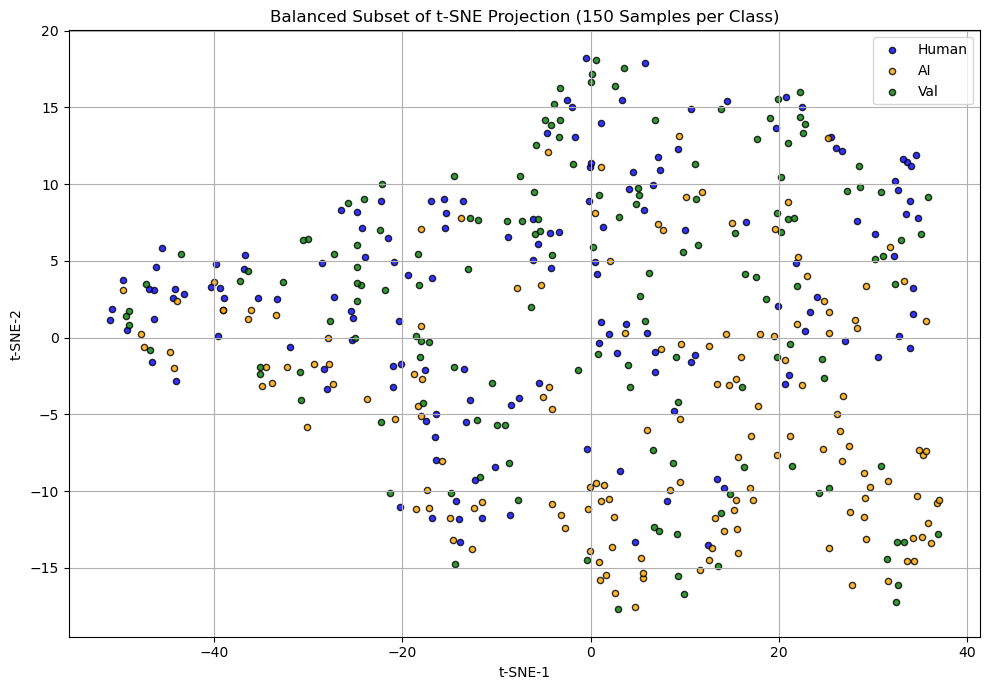

In [111]:
import pandas as pd

# ------------------------------
# Step 1: Build dataframe from embeddings and labels
# ------------------------------
df = pd.DataFrame(X_tsne, columns=['x', 'y'])
df['label'] = labels

# ------------------------------
# Step 2: Sample 150 per class
# ------------------------------
balanced_df = df.groupby('label').sample(n=150, random_state=42)

# ------------------------------
# Step 3: Plot Subset
# ------------------------------
plt.figure(figsize=(10, 7))
for label, color in zip(['Human', 'AI', 'Val'], ['blue', 'orange', 'green']):
    subset = balanced_df[balanced_df['label'] == label]
    plt.scatter(subset['x'], subset['y'], c=color, label=label, s=20, alpha=0.8, edgecolor='k')

plt.title("Balanced Subset of t-SNE Projection (150 Samples per Class)")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Plot Summary
This is a balanced 2D t-SNE projection showing:

🔵 150 Human samples

🟠 150 AI-generated samples

🟢 150 Validation samples

The purpose of this plot is to reduce clutter from the full dataset and allow clearer visualization of class separability.

 Observations
#1. Class Distributions Are Still Separable
Human samples (🔵) tend to occupy upper-left to center-top region.

AI samples (🟠) are more bottom and right-skewed.

This pattern matches the full t-SNE plot, confirming that the projection is consistent.

#2. Validation Points (🟢) Are Mixed
Val points are not confined to a region.

They span across both Human and AI regions.

This suggests:

Some val samples resemble human-written texts

Others resemble AI-generated ones

And some are ambiguous or hard to classify

###3. No Major Outliers
All three classes are reasonably well distributed.

No extreme outlier clusters—indicating decent t-SNE projection quality.

 Usefulness of This Plot
Feature	Benefit
Balanced	Prevents visual bias from class imbalance
Cleaner view	Easier to see class overlap and separation
Good for Decision Boundary	Ideal for retraining and visualizing classifiers